In [1]:
#Dashboard con función dashboard()

In [2]:
import yfinance as yf
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xlwings as xw
sns.set()

In [3]:
#Conexión temporal a libro de excel (solo para pruebas)

In [37]:
libro = xw.Book(r'D:\xlwings\DASHBOARD.xlsx')

In [6]:
#Definimos la función dashboard

In [32]:
def dashboard():
    #libro = xw.Book.caller()
    
    #Definimos los objetos hojas
    dashboard = libro.sheets[0]
    precios = libro.sheets[1]
    
    #Capturamos variables de entrada
    ticker = dashboard.range("C7").value
    inicio = dashboard.range("E7").value
    fin = dashboard.range("G7").value
    frecuencia = dashboard.range("J7").value
    indice = dashboard.range("J30").value
   
    #Creamos un dataframe con los datos del api de yahoo finance
    yf.pdr_override()
    price_adj_close = pdr.get_data_yahoo([ticker, indice], start=inicio, end=fin)["Adj Close"]
    
    #Quitamos el caracter "^" del ticker del indice para operar de manera correcta
    price_adj_close.rename(columns = {indice:indice.replace("^", "")}, inplace = True)
    indice = indice.replace("^", "")   
    
    #Creamos y añadimos el grafico de precios
    grafico = plt.figure(figsize = (25,10))
    price_adj_close[ticker].plot(fontsize = 15)
    plt.title(ticker, fontsize = 30)
    plt.xlabel ("Fecha", fontsize = 20)
    plt.ylabel ("Precio de cierre ajustado", fontsize = 20)
    plt.show()
    dashboard.pictures.add(grafico,name = "Activo", update = True,
                      left = dashboard.range("D10").left,
                      top = dashboard.range("D10").top,
                      scale = 0.7)
    
    #Calculamos y añadimos los precios y rendimientos del periodo
    primero = price_adj_close.iloc[0,0]
    ultimo = price_adj_close.iloc[-1,0]
    maximo = price_adj_close.iloc[:,0].max()
    minimo = price_adj_close.iloc[:,0].min()
    retorno_periodo = (ultimo - primero) / primero
    dashboard.range("G23").options(transpose = True).value = [primero, ultimo, maximo, minimo, retorno_periodo]
    
    #Grafico comparativo entre el activo y el indice
    escala = price_adj_close.div(price_adj_close.iloc[0])
    grafico_2 = plt.figure(figsize = (25,10))
    escala[ticker].plot(fontsize = 15)
    escala[indice].plot(fontsize = 15)
    plt.title("Comparación entre " + ticker + " e indice " + indice, fontsize = 30)
    plt.xlabel ("Fecha", fontsize = 20)
    plt.ylabel ("Precio de cierre ajustado", fontsize = 20)
    plt.legend(fontsize = 15)
    plt.show()
    dashboard.pictures.add(grafico_2,name = "Comparativo", update = True,
                      left = dashboard.range("D32").left,
                      top = dashboard.range("D32").top,
                      scale = 0.7)
    
    #Calculamos rendimientos
    rendimientos = price_adj_close.resample(frecuencia).last().dropna().pct_change().dropna()
    
    #Creamos grafico comparativo entre rendimientos
    grafico_3 = plt.figure(figsize = (25,10))
    sns.regplot(data = rendimientos, x = indice, y = ticker)
    plt.title("Comparativo de rendimientos entre " + ticker+ " e indice " + indice, fontsize = 30)
    plt.xlabel ("Rendimientos del ticker", fontsize = 30)
    plt.ylabel ("Rendimientos del indice", fontsize = 30)
    plt.show()
    dashboard.pictures.add(grafico_3,name = "Rendimientos", update = True,
                      left = dashboard.range("C45").left,
                      top = dashboard.range("C45").top,
                      scale = 0.5)
    
    #Regresión lineal
    modelo = ols(ticker + "~" + indice, data = rendimientos)
    resultados = modelo.fit()
    print(resultados.summary())
    
    #Calculamos y añadimos estadisticos
    observaciones = len(rendimientos)
    correlacion = rendimientos.corr().iloc[0,1]
    beta = resultados.params[1]
    intercepto = resultados.params[0]
    rcuadrado = resultados.rsquared
    p = resultados.pvalues[1]
    conf_izq = resultados.conf_int().iloc[1,0]
    conf_der = resultados.conf_int().iloc[1,1]
    estadisticos = [observaciones, correlacion, beta, intercepto, rcuadrado, p, conf_izq, conf_der]
    dashboard.range("J45").options(transpose = True).value = estadisticos 
    
    #Escribimos los datos de los precios en la hoja precios
    precios.range("A1").expand().clear_contents()
    precios.range("A1").value = price_adj_close
    
    
    
  

[*********************100%%**********************]  2 of 2 completed


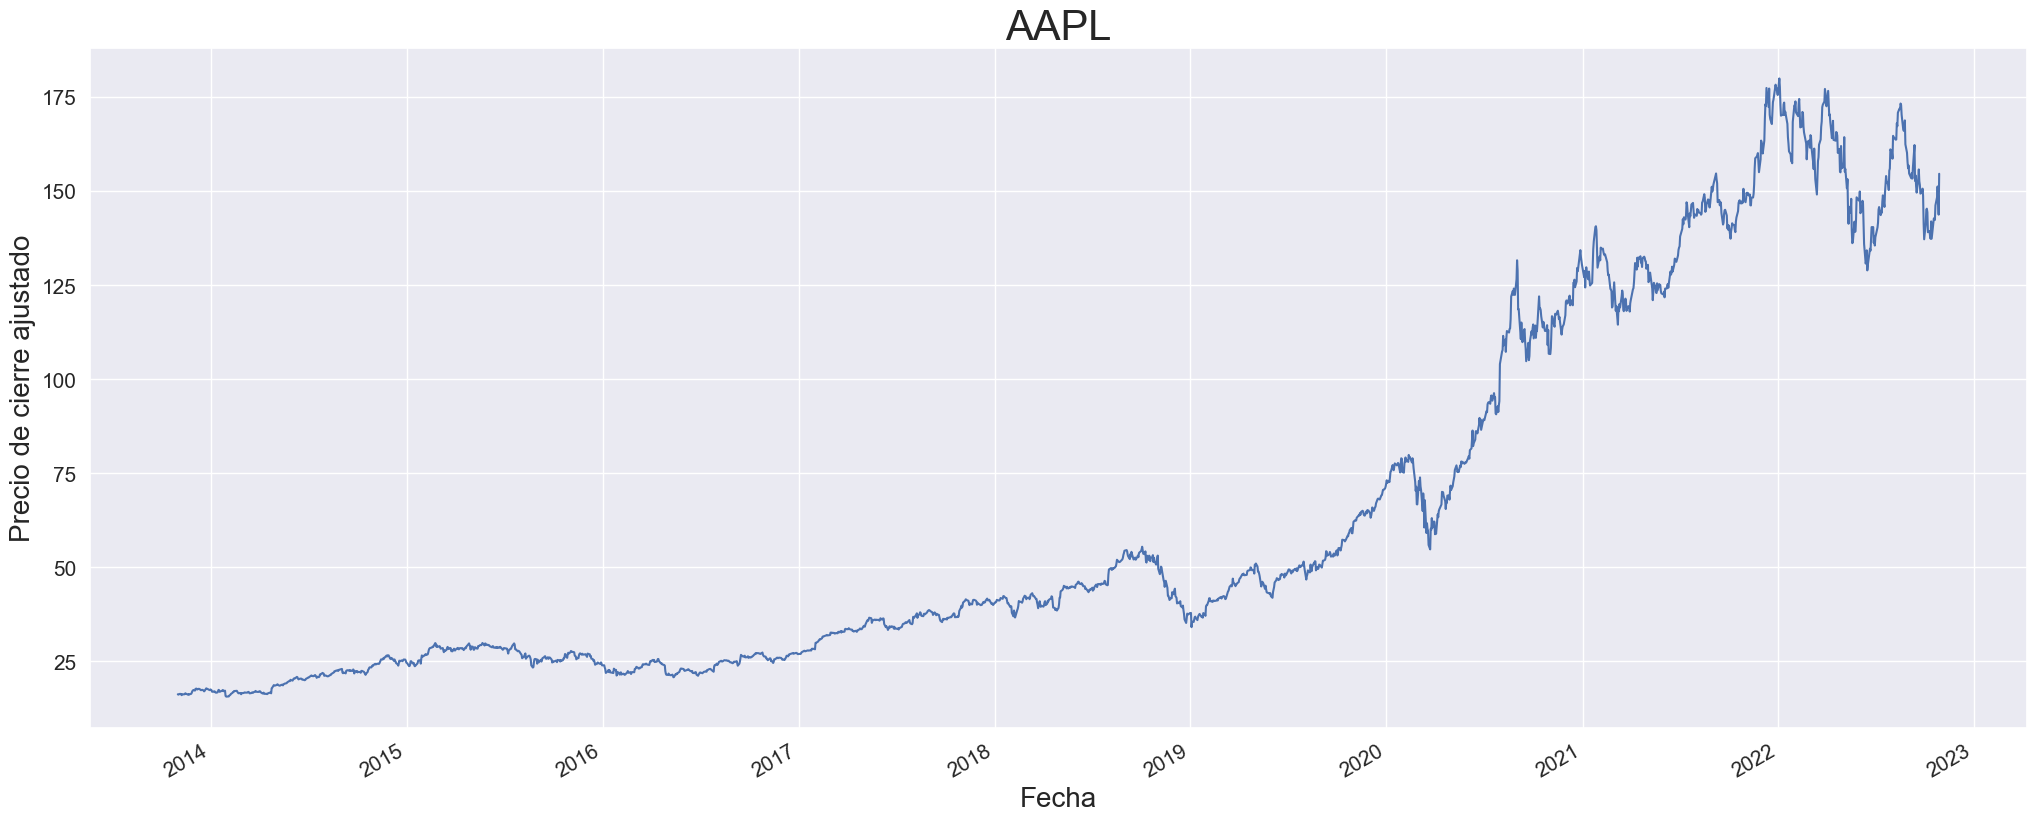

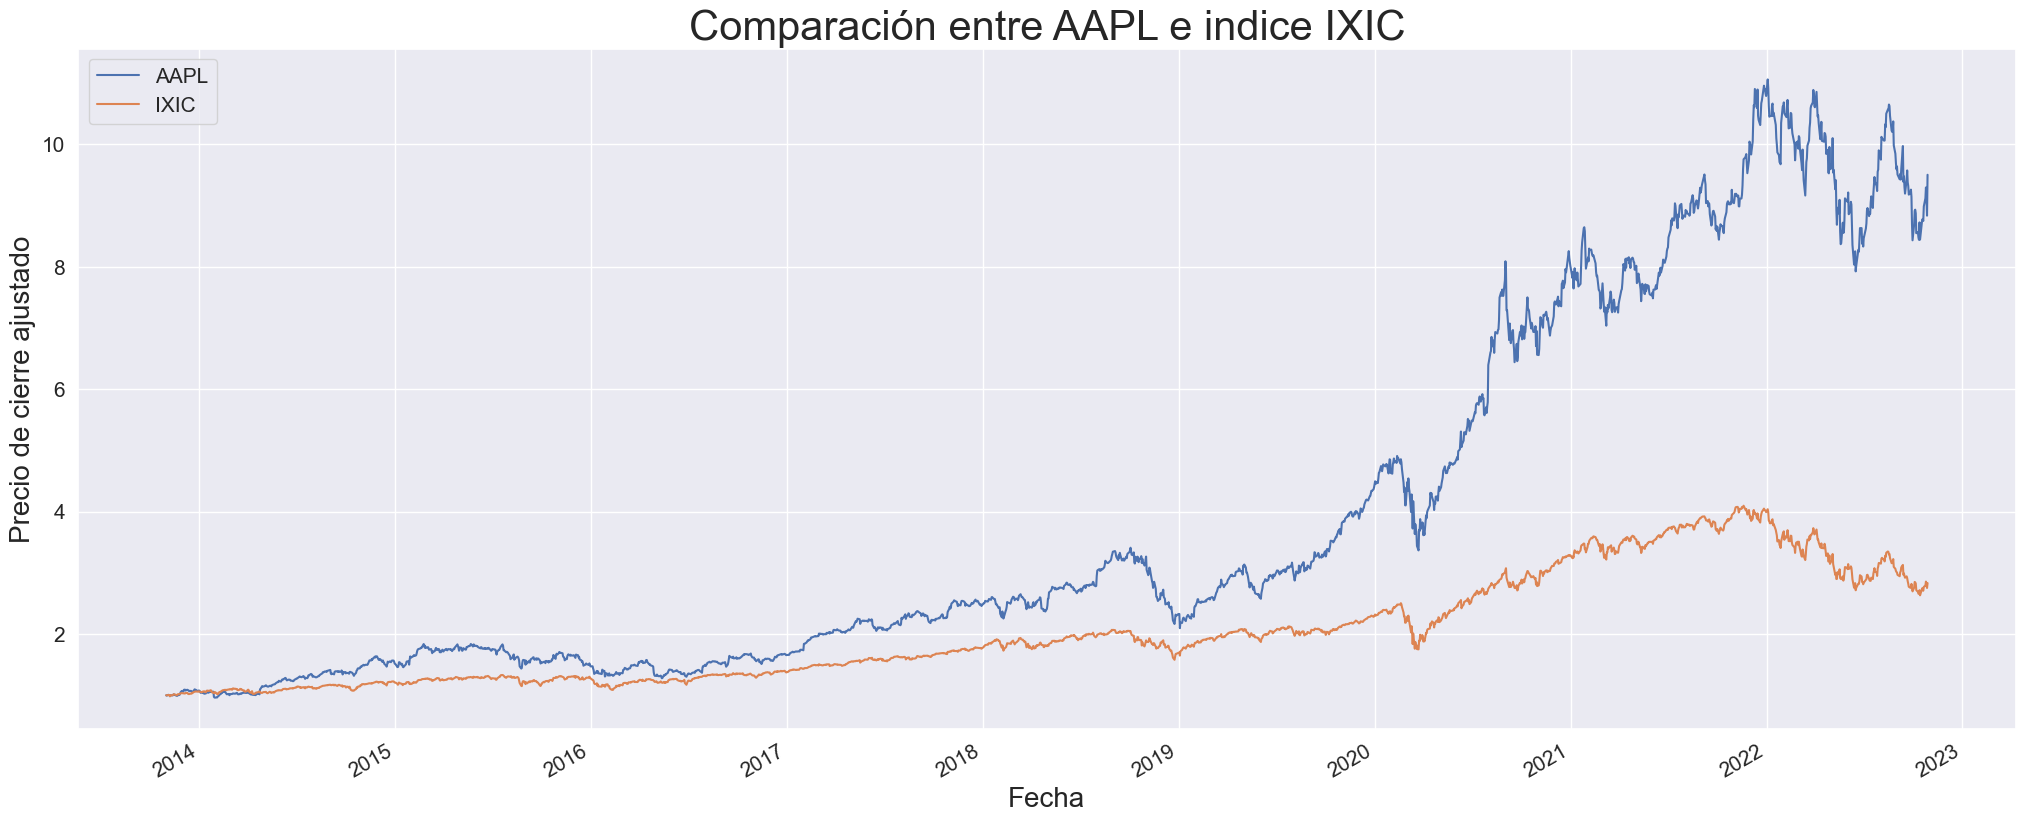

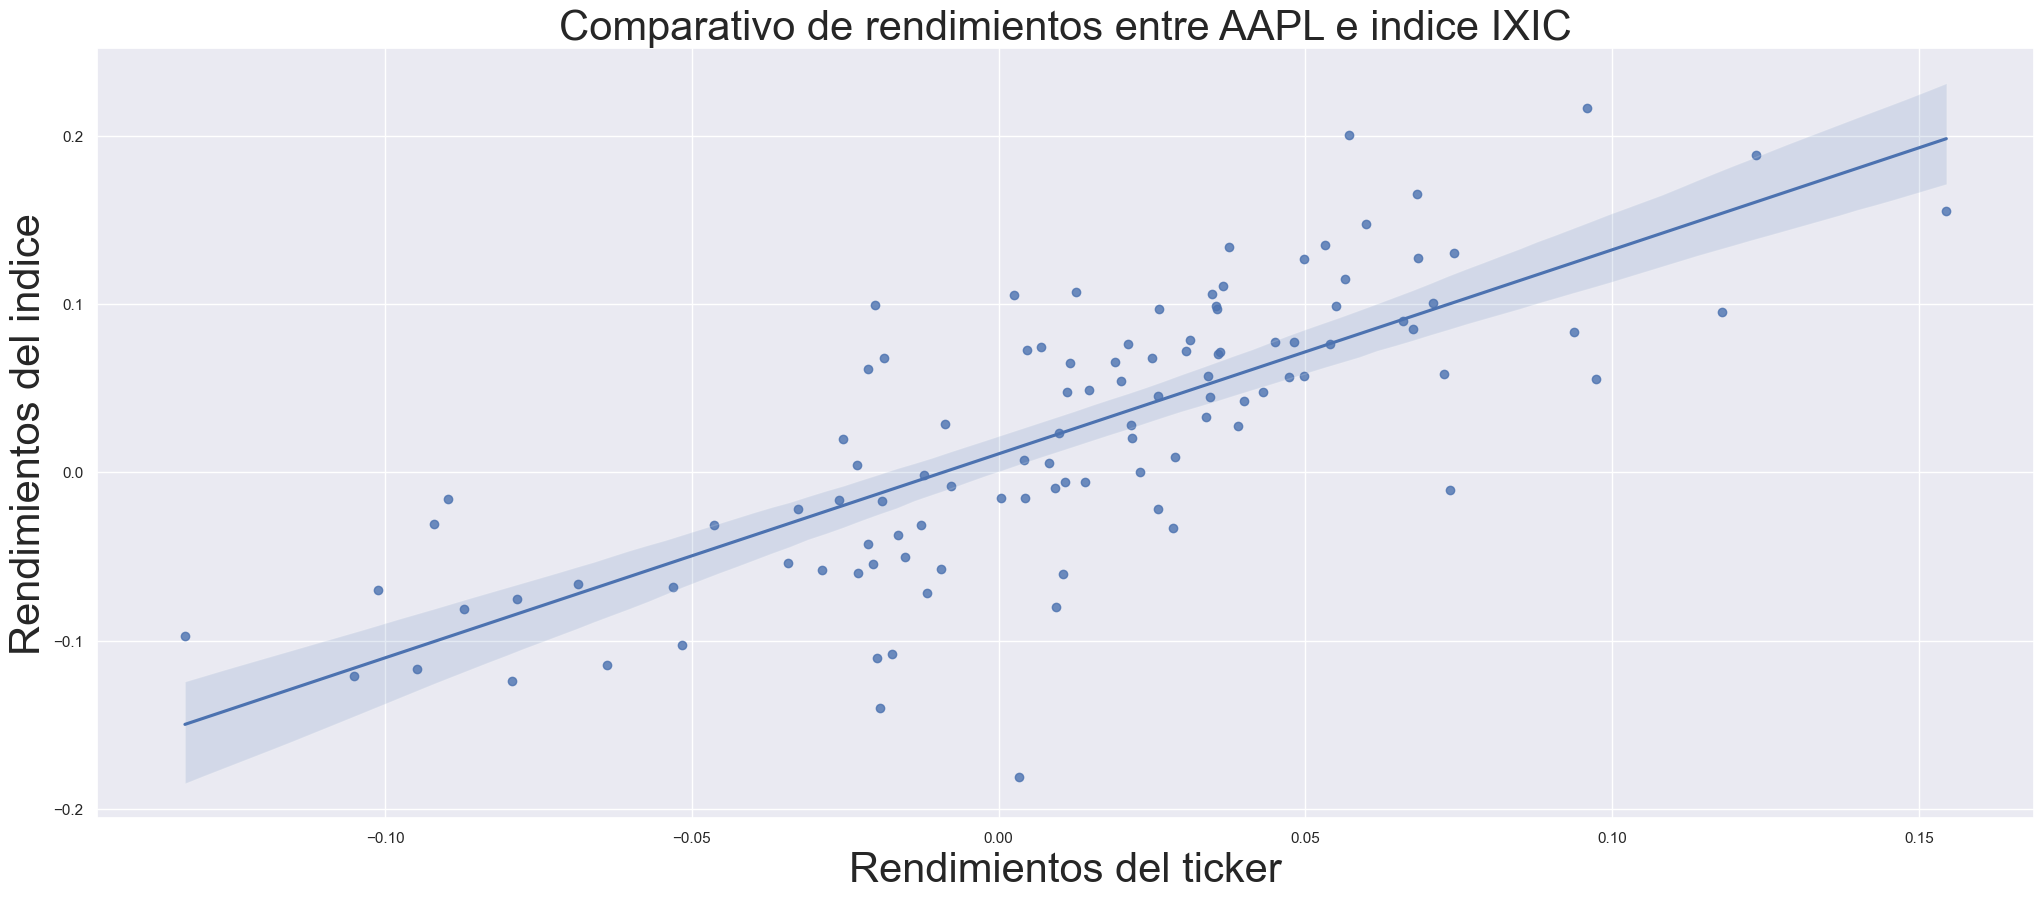

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     144.4
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           1.65e-21
Time:                        18:13:08   Log-Likelihood:                 164.99
No. Observations:                 108   AIC:                            -326.0
Df Residuals:                     106   BIC:                            -320.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0110      0.005      2.107      0.0

In [36]:
dashboard()

In [43]:
def borrarvalores():
    #Hacemos caller del libro
    #libro = xw.Book.caller()
    
    #Definimos los objetos hojas
    dashboard = libro.sheets[0]
    precios = libro.sheets[1]
    
    #Borrar variables input
    dashboard.range("C7").clear_contents()
    dashboard.range("E7").clear_contents()
    dashboard.range("G7").clear_contents()
    dashboard.range("J7").clear_contents()
    dashboard.range("J30").clear_contents()
    
    #Borrar valores de los precios
    dashboard.range("G23").clear_contents()
    dashboard.range("G24").clear_contents()
    dashboard.range("G25").clear_contents()
    dashboard.range("G26").clear_contents()
    dashboard.range("G27").clear_contents()
    
    #Borrar indice
    dashboard.range("J30").clear_contents()
    
    #Borrar estadisticos
    dashboard.range("J45").expand().clear_contents()
    
    #Borrar contenido de hoja precio
    precios.range("A1").expand().clear_contents()

In [44]:
borrarvalores()